<div style="padding:50px; color:white; background:#07D; text-align:center;">
    <h1 style="font-size:52px; font-weight:bold; margin:0;">
        Projet - OUTINFO
    </h1>
    <h2 style="font-size:45px; font-weight:normal; margin:10px 0;">
        Médecins en France
    </h2>
    <h3 style="font-size:20px; font-weight:normal; margin:10px 0;">
        <br> Ahina Durrieu - Maïna Boivent
    </h3>
</div>


<h2 style="padding:16px; color:white; background:#07D">Travail envisagé</h2>

**Données:**

- https://public.opendatasoft.com/explore/dataset/medecins/information/?flg=fr&location=8,48.49659,1.94733&basemap=jawg.light

Liste, localisation et tarifs des professionnels de santé en France en 2024.

Format : GeoJSON

<br>

- https://statistiques-locales.insee.fr/#c=indicator&i=filosofi.nbmenfisc&i2=filosofi.pimp&s=2021&s2=2021&selcodgeo=04&t=A01&t2=A01&view=map2

Statistiques locales en France : nombre d'habitants par département en 2023 et 2024, et nombre de médecins par département en 2023.

Format : CSV  
<br>

- https://www.regions-et-departements.fr/

Départements associés à leur région. \
Téléchargement des données en format PDF puis utilisation d'un convertisseur en ligne afin d'obtenir les données en format HTML.

Format : HTML

<br>


**Analyses envisagées:**

- Comparaison du nombre de médecins en France en 2023 et 2024

- Comparaison de la concentration des médecins par département (en fonction du nombre d'habitants)

- Le montant constaté par séance par medecin par patient

- Observation de la répartition de médecins hommes et femmes sur le territoire français, par département

<br> <br>

<h2 style="padding:16px; color:white; background:#07D">Imports</h2>


In [40]:
import numpy as np # import du package 'numpy' avec alias 'np'
import pandas as pd # import du package 'pandas' avec alias 'pd'
from SRC.tools import show, inspect  # import des fonctions du module 'tools'
from IPython.core.interactiveshell import InteractiveShell as ish

import matplotlib.pyplot as mp # import du package 'matplotlib' avec alias 'mp'
import seaborn as sb # import du package 'seaborn' avec alias 'sb'

from SRC.tools import show, load, fetch

from bs4 import BeautifulSoup
import requests

import geopandas as gpd

import requests
from io import StringIO

import folium
from IPython.display import display, HTML
from ipywidgets import interact, widgets

import re

import warnings; warnings.filterwarnings('ignore') # on enlève les 'warning' éventuels

<br> <br>

<h2 style="padding:16px; color:white; background:#07D">Etape 1 - Maillon fetch</h2>

<br> <br>

---
### 1 - Statistiques locales en France

<br>
Le fichier a été téléchargé, puis déposé sur GitHub, pour pouvoir y accéder à l'aide d'un url.

Les séparateurs sont '$;$' et les deux premières lignes sont à ignorer.

In [41]:
url = "https://raw.githubusercontent.com/ahina0/projet_outinfo/main/statistiques.csv" # url of the github csv file
response = requests.get(url) # download the csv file from github
response.raise_for_status()
statistiques = pd.read_csv(StringIO(response.text), sep=';', skiprows=2) # load the data into a dataframe
statistiques.head() # display the first few rows

,Code,Libellé,Médecin généraliste (en nombre) 2023,Chirurgien dentiste (en nombre) 2023,Population municipale 2022,Estimations de population 2024
0,01,Ain,435,321,671289,679498
1,02,Aisne,372,226,525558,521632
2,03,Allier,278,168,334715,332708
3,04,Alpes-de-Haute-Provence,169,90,167179,168161
4,05,Hautes-Alpes,182,89,141677,141661


<br>

---
### 2 - Les départements et leur région

<br>

Le fichier a été téléchargé, puis déposé sur GitHub, pour pouvoir y accéder à l'aide d'un url. \
On récupère les données du fichier HTML qu'on enregistre dans un data frame. \
La première ligne du fichier HTML est le nom des colonnes, on l'utilise donc. On ne renomme pas la première colonne car on ne l'utilisera pas.

In [42]:
url = "https://raw.githubusercontent.com/ahina0/projet_outinfo/main/regions-et-departements-francais-converted.html" # url of the github html file
response = requests.get(url) # download the html file from github
response.raise_for_status()
soup = BeautifulSoup(response.text, 'html.parser') # parse the html content with beautifulsoup
rows = soup.find_all('tr') # identify the tags containing the data ; assume the data is in <tr> tags with <td> for each column
# extract and structure the data
data = []
for row in rows:
    cells = row.find_all('td')
    if len(cells) == 3:  # number, department, region
        num = cells[0].get_text(strip=True)        # number
        dept = cells[1].get_text(strip=True)       # department
        region = cells[2].get_text(strip=True)     # region
        data.append([num, dept, region])
dept_region = pd.DataFrame(data) # create a DataFrame with the extracted data
dept_region.columns = dept_region.iloc[0] # set the first row as the header
dept_region = dept_region[1:].reset_index(drop=True) # remove the header row from the data
dept_region.head()

,‌NUMÉRODépartement,DÉPARTEMENT,RÉGION
0,01,Ain,Auvergne-Rhône-Alpes
1,02,Aisne,Hauts-de-France
2,03,Allier,Auvergne-Rhône-Alpes
3,04,Alpes-de-Haute-Provence,Provence-Alpes-Côte d'Azur
4,05,Hautes-Alpes,Provence-Alpes-Côte d'Azur


<br>

---
### 3 - Liste, localisation et tarifs des professionnels de santé en France.

<br>

Le fichier était trop lourd pour être téléchargé, et un url est directement disponible depuis la page web pour accéder à ces données. On utilise donc cet url. On a aussi uniquement sélectionné les données correspondant à "médecin généraliste", pour que le fichier soit moins lourd.

Comme le fichier est lourd, cette cellule est longue à s'exécuter.

In [43]:
# url of the GeoJSON file
url = "https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/medecins/exports/geojson?lang=fr&refine=libelle_profession%3A%22M%C3%A9decin%20g%C3%A9n%C3%A9raliste%22&timezone=Europe%2FBerlin"
response = requests.get(url, stream=True) # download the GeoJSON file
professionnels_sante = gpd.read_file(StringIO(response.text)) # load the geojson file into geopandas
professionnels_sante.head()

Skipping field libelle_acte_clinique: unsupported OGR type: 5


,civilite,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,...,libelle_activite,libelle,tarif_1,tarif_2,remboursement,exoneration_tm,libelle_phase,tarif_base_de_remboursement_securite_sociale,concat,geometry
0,Femme,04.66.52.82.70,45,Angiologue,Libéral intégral,Secteur 1 ou conventionné,N,Lecteur de carte Sesam Vitale,EJQM0030,93.0,...,Opérateur Principal,Échographie-doppler des veines des membres inf...,75.6,75.6,None,2.0,Une seule phase de traitement,75.60,PASCALE FAISSEPASCALE FAISSE 20 RUE D'AVEJAN ...,POINT (4.07964 44.12321)
1,Femme,04.66.22.14.22,45,None,Libéral intégral,Secteur 1 ou conventionné,N,Lecteur de carte Sesam Vitale,TCG,NaN,...,None,None,None,None,None,NaN,None,NaN,CAROLINE SEROPIANSELARL C S LE SIRIUS PLACE DE...,POINT (4.41614 44.01287)
2,Homme,06.45.81.56.99,45,None,Libéral intégral,Secteur 1 ou conventionné,N,Lecteur de carte Sesam Vitale,EQQM0060,116.0,...,Opérateur Principal,Mesure de la pression intraartérielle d'un mem...,21.12,21.12,None,2.0,Une seule phase de traitement,21.12,MICHAEL ADAMCABINET DU DR MICHAEL ADAM PARC GE...,POINT (4.36865 43.82239)
3,Homme,04.67.85.66.55,45,None,Libéral intégral,Secteur 1 ou conventionné,N,Lecteur de carte Sesam Vitale,G,NaN,...,None,None,None,None,None,NaN,None,NaN,FRANCOIS JOUBERTCABINET DU DR FRANCOIS JOUBERT...,POINT (3.60749 43.99271)
4,Homme,04.66.74.10.22,45,None,Libéral intégral,Secteur 1 ou conventionné,N,Lecteur de carte Sesam Vitale,G,NaN,...,None,None,None,None,None,NaN,None,NaN,MARC BARAGNON 2 BIS PLACE DU CASTELLAS 30540...,POINT (4.30888 43.79005)


### <br> <br>

<h2 style="padding:16px; color:white; background:#07D">Etape 2 - Maillons clean et structure</h2>

<br> <br>

---
### 1 -  Statistiques locales en France. 

<br>

Le nombre de chirurgiens dentistes n'est d'aucune utilité, car les chirurgiens dentistes ne figurent pas dans la database sur les professionnels de santé. On supprime donc cette colonne.

On renomme la colonne du nombre de médecins généralistes en 2023 et du code du département pour plus de convenience.

In [44]:
statistiques = statistiques.drop(columns=["Chirurgien dentiste (en nombre) 2023"]) # drop the specified column
statistiques = statistiques.rename(columns = {"Médecin généraliste (en nombre) 2023":"nb_medecins_2023", "Code":"dep_code"}) # modify columns names
statistiques.head() # display the first rows

,dep_code,Libellé,nb_medecins_2023,Population municipale 2022,Estimations de population 2024
0,01,Ain,435,671289,679498
1,02,Aisne,372,525558,521632
2,03,Allier,278,334715,332708
3,04,Alpes-de-Haute-Provence,169,167179,168161
4,05,Hautes-Alpes,182,141677,141661


<br>

---
### 2 -  Liste, localisation et tarifs des professionnels de santé en France. 

<br>

Les colonnes ayant un nom de type "column_*number*" ne sont pas gardées, sauf "column_10", qui est le numéro de téléphone du médecin. On renomme cette colonne, et on supprime les autres.

In [45]:
professionnels_sante.rename(columns={"column_10": "numero_telephone"}, inplace=True) # rename the column
# keep only the columns that do not match the pattern 'column_"number"'
filtered_columns = [col for col in professionnels_sante.columns if not col.startswith("column_")]; professionnels_sante = professionnels_sante[filtered_columns] 
professionnels_sante.head()

,civilite,numero_telephone,nom,adresse,libelle_profession,type_dacte_realise,nom_acte,coordonnees,commune,code_insee,...,libelle_activite,libelle,tarif_1,tarif_2,remboursement,exoneration_tm,libelle_phase,tarif_base_de_remboursement_securite_sociale,concat,geometry
0,Femme,04.66.52.82.70,PASCALE FAISSE,PASCALE FAISSE 20 RUE D'AVEJAN 30100 ALES,Médecin généraliste,Acte technique,"Echodoppler des veines,",None,Alès,30007,...,Opérateur Principal,Échographie-doppler des veines des membres inf...,75.6,75.6,None,2.0,Une seule phase de traitement,75.60,PASCALE FAISSEPASCALE FAISSE 20 RUE D'AVEJAN ...,POINT (4.07964 44.12321)
1,Femme,04.66.22.14.22,CAROLINE SEROPIAN,SELARL C S LE SIRIUS PLACE DES CORDELIERS 307...,Médecin généraliste,Acte clinique,None,None,Uzès,30334,...,None,None,None,None,None,NaN,None,NaN,CAROLINE SEROPIANSELARL C S LE SIRIUS PLACE DE...,POINT (4.41614 44.01287)
2,Homme,06.45.81.56.99,MICHAEL ADAM,CABINET DU DR MICHAEL ADAM PARC GEORGES BESSE ...,Médecin généraliste,Acte technique,Exploration de l'appareil circulatoire périphé...,None,Nîmes,30189,...,Opérateur Principal,Mesure de la pression intraartérielle d'un mem...,21.12,21.12,None,2.0,Une seule phase de traitement,21.12,MICHAEL ADAMCABINET DU DR MICHAEL ADAM PARC GE...,POINT (4.36865 43.82239)
3,Homme,04.67.85.66.55,FRANCOIS JOUBERT,CABINET DU DR FRANCOIS JOUBERT MAISON DE SANTE...,Médecin généraliste,Acte clinique,None,None,Le Vigan,30350,...,None,None,None,None,None,NaN,None,NaN,FRANCOIS JOUBERTCABINET DU DR FRANCOIS JOUBERT...,POINT (3.60749 43.99271)
4,Homme,04.66.74.10.22,MARC BARAGNON,2 BIS PLACE DU CASTELLAS 30540 MILHAUD,Médecin généraliste,Acte clinique,None,None,Milhaud,30169,...,None,None,None,None,None,NaN,None,NaN,MARC BARAGNON 2 BIS PLACE DU CASTELLAS 30540...,POINT (4.30888 43.79005)


<br>

On ne garde que les colonnes qui nous intéressent pour les analyses.

On visualise les colonnes restantes :

In [46]:
professionnels_sante.columns # visualisation of the remaining columns

Index(['civilite', 'numero_telephone', 'nom', 'adresse', 'libelle_profession',
       'type_dacte_realise', 'nom_acte', 'coordonnees', 'commune',
       'code_insee', 'epci_name', 'dep_name', 'reg_name', 'epci_code',
       'reg_code', 'dep_code', 'activite_principale', 'code', 'phase',
       'libelle_regroupement', 'accord_prealable', 'code_ccam_activite_phase',
       'regroupement', 'libelle_activite', 'libelle', 'tarif_1', 'tarif_2',
       'remboursement', 'exoneration_tm', 'libelle_phase',
       'tarif_base_de_remboursement_securite_sociale', 'concat', 'geometry'],
      dtype='object')

<br>

La colonne "libelle_profession" est inutile, car on a conservé que les lignes qui correspondent aux médecins généralistes dans la base de données initiale.

Pour plus de complexité à traiter les données, on décide de ne pas conserver les colonnes de la commune, du département et de la région. On créera la colonne du département à partir de la colonne adresse.

Pour identifier un médecin, on utilisera son nom et son numéro de téléphone.

On ne conserve donc que les colonnes sur le nom, numéro de téléphone, genre et adresse du médecin, ainsi que le tarif et le type de la consultation.

In [47]:
columns_to_keep = ["nom", "numero_telephone", "civilite", "adresse", "tarif_1", "tarif_2", "remboursement", "tarif_base_de_remboursement_securite_sociale", "type_dacte_realise"] # the columns to keep
professionnels_sante = professionnels_sante[columns_to_keep]
professionnels_sante.head(20) # display the 20 first rows, to have an idea of the values

,nom,numero_telephone,civilite,adresse,tarif_1,tarif_2,remboursement,tarif_base_de_remboursement_securite_sociale,type_dacte_realise
0,PASCALE FAISSE,04.66.52.82.70,Femme,PASCALE FAISSE 20 RUE D'AVEJAN 30100 ALES,75.6,75.6,None,75.60,Acte technique
1,CAROLINE SEROPIAN,04.66.22.14.22,Femme,SELARL C S LE SIRIUS PLACE DES CORDELIERS 307...,None,None,None,NaN,Acte clinique
2,MICHAEL ADAM,06.45.81.56.99,Homme,CABINET DU DR MICHAEL ADAM PARC GEORGES BESSE ...,21.12,21.12,None,21.12,Acte technique
3,FRANCOIS JOUBERT,04.67.85.66.55,Homme,CABINET DU DR FRANCOIS JOUBERT MAISON DE SANTE...,None,None,None,NaN,Acte clinique
4,MARC BARAGNON,04.66.74.10.22,Homme,2 BIS PLACE DU CASTELLAS 30540 MILHAUD,None,None,None,NaN,Acte clinique
5,STEPHANIE BOURQUARDEZ,04.66.77.11.68,Femme,CABINET DU DR STEPHANIE BOURQUARDEZ 1 LOTISS. ...,None,None,None,NaN,Acte clinique
6,GWENOLA BALDASSARI,04.66.77.16.33,Femme,RESIDENCE LES ARCADES 15 RUE DU LAC 30260 QUI...,69.12,69.12,None,69.12,Acte technique
7,GWENOLA BALDASSARI,04.66.77.16.33,Femme,RESIDENCE LES ARCADES 15 RUE DU LAC 30260 QUI...,None,None,None,NaN,Acte clinique
8,DAVID COSTA,04.48.06.00.40,Homme,CABINET DU DR DAVID COSTA SISA MEDICARREE 9 RU...,12.73,9.8,None,12.73,Acte technique
9,ANNE LAURE CASES MIGNOT,05.61.11.73.56,Femme,7 RUE FLORA TRISTAN 31880 LA SALVETAT ST GILLES,12.73,9.8,None,12.73,Acte technique


<br>

On remarque que beaucoup de valeurs de la colonne "remboursement" semblent avoir la valeur "None". On compte le nombre de ces valeurs pour décider de garder cette colonne ou non.

Pourcentage de valeurs None dans la colonne remboursement : 99%.


<Axes: xlabel='remboursement'>

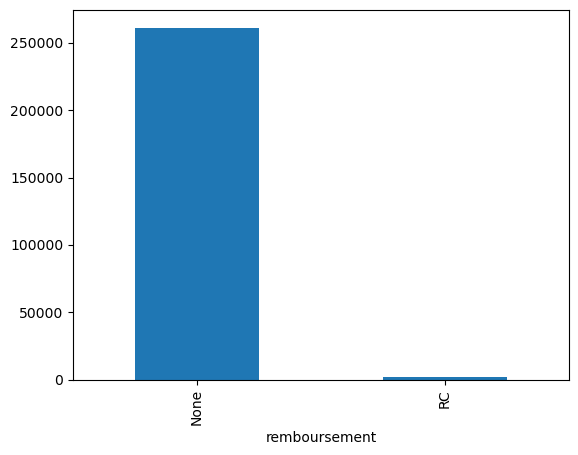

In [48]:
# count the number of None values in the "remboursement" column. It is either Na or "None"
none_count = professionnels_sante[(professionnels_sante["remboursement"].isna()) | (professionnels_sante["remboursement"] == "None")].shape[0]
total_rows = professionnels_sante.shape[0] # count the number of rows in the dataframe
print(f"Pourcentage de valeurs None dans la colonne remboursement : {(none_count/total_rows)*100:.0f}%.") # prints the percentage of None values, with no decimal

professionnels_sante["remboursement"] = professionnels_sante["remboursement"].fillna("None") # if Na, write "None"
# display the repartition of the values of the remboursement column
professionnels_sante.groupby("remboursement").count()["civilite"].plot.bar()

On décide de supprimer cette colonne.

In [49]:
professionnels_sante = professionnels_sante.drop(columns=["remboursement"]) # delete the column
professionnels_sante.head()

,nom,numero_telephone,civilite,adresse,tarif_1,tarif_2,tarif_base_de_remboursement_securite_sociale,type_dacte_realise
0,PASCALE FAISSE,04.66.52.82.70,Femme,PASCALE FAISSE 20 RUE D'AVEJAN 30100 ALES,75.6,75.6,75.60,Acte technique
1,CAROLINE SEROPIAN,04.66.22.14.22,Femme,SELARL C S LE SIRIUS PLACE DES CORDELIERS 307...,None,None,NaN,Acte clinique
2,MICHAEL ADAM,06.45.81.56.99,Homme,CABINET DU DR MICHAEL ADAM PARC GEORGES BESSE ...,21.12,21.12,21.12,Acte technique
3,FRANCOIS JOUBERT,04.67.85.66.55,Homme,CABINET DU DR FRANCOIS JOUBERT MAISON DE SANTE...,None,None,NaN,Acte clinique
4,MARC BARAGNON,04.66.74.10.22,Homme,2 BIS PLACE DU CASTELLAS 30540 MILHAUD,None,None,NaN,Acte clinique


<br>

Les colonnes tarif_1 et tarif_2 sont de type chaine de charactères. On les convertit en chiffres.

In [50]:
# convert the columns tarif_1 and tarif_2 to numbers
professionnels_sante["tarif_1"] = pd.to_numeric(professionnels_sante["tarif_1"], errors="coerce")
professionnels_sante["tarif_2"] = pd.to_numeric(professionnels_sante["tarif_2"], errors="coerce")

<br>

Les colonnes tarif_1 et tarif_base_de_remboursement_securite_sociale semblent avoir des valeurs très proches. On calcule la différence entre les deux, et on vérifie si lorsqu'une valeur n'est pas renseignée, l'autre ne l'est pas non plus.

On fait de même pour tarif_1 et tarif_2.

In [51]:
# calculate the difference between tarif_1 and tarif_base_de_remboursement_securite_sociale
ecart = pd.DataFrame({"difference_remboursement": professionnels_sante["tarif_1"] - professionnels_sante["tarif_base_de_remboursement_securite_sociale"]})
print(f"Moyenne de la différence entre le tarif et la base de remboursement : {ecart["difference_remboursement"].mean():.2f}") # display the mean of the difference, ignoring NaN values

none_and_number_count = (
    (professionnels_sante["tarif_1"].isna() & professionnels_sante["tarif_base_de_remboursement_securite_sociale"].notna()) |
    (professionnels_sante["tarif_1"].notna() & professionnels_sante["tarif_base_de_remboursement_securite_sociale"].isna())
).sum() # count rows where one column is NaN and the other is a number

print(f"Nombre de lignes où une seule des deux valeurs est renseignée: {none_and_number_count}")

Moyenne de la différence entre le tarif et la base de remboursement : 0.09
Nombre de lignes où une seule des deux valeurs est renseignée: 0


<br>

On considère donc que les deux colonnes sont identiques.

On compare maintenant les colonnes tarif_1 et tarif_2.

In [52]:
# calculate the difference between tarif_1 and tarif_2
ecart = pd.DataFrame({"difference_tarifs": professionnels_sante["tarif_1"] - professionnels_sante["tarif_2"]})
print(f"Moyenne de la différence entre les deux tarifs : {ecart["difference_tarifs"].mean():.2f}") # display the mean of the difference, ignoring NaN values

none_and_number_count = (
    (professionnels_sante["tarif_1"].isna() & professionnels_sante["tarif_2"].notna()) |
    (professionnels_sante["tarif_1"].notna() & professionnels_sante["tarif_2"].isna())
).sum() # count rows where one column is NaN and the other is a number

print(f"Nombre de lignes où une seule des deux valeurs est renseignée: {none_and_number_count}")

Moyenne de la différence entre les deux tarifs : 2.15
Nombre de lignes où une seule des deux valeurs est renseignée: 0


<br>

L'écart entre les deux colonnes est de nouveau faible, et on a toujours les deux valeurs, ou aucune des deux.

On choisit donc de ne garder que la colonne tarif_1 parmis les trois.

In [53]:
professionnels_sante = professionnels_sante.drop(columns=["tarif_2", "tarif_base_de_remboursement_securite_sociale"]) # delete the unnecessary columns
professionnels_sante.head()

,nom,numero_telephone,civilite,adresse,tarif_1,type_dacte_realise
0,PASCALE FAISSE,04.66.52.82.70,Femme,PASCALE FAISSE 20 RUE D'AVEJAN 30100 ALES,75.60,Acte technique
1,CAROLINE SEROPIAN,04.66.22.14.22,Femme,SELARL C S LE SIRIUS PLACE DES CORDELIERS 307...,NaN,Acte clinique
2,MICHAEL ADAM,06.45.81.56.99,Homme,CABINET DU DR MICHAEL ADAM PARC GEORGES BESSE ...,21.12,Acte technique
3,FRANCOIS JOUBERT,04.67.85.66.55,Homme,CABINET DU DR FRANCOIS JOUBERT MAISON DE SANTE...,NaN,Acte clinique
4,MARC BARAGNON,04.66.74.10.22,Homme,2 BIS PLACE DU CASTELLAS 30540 MILHAUD,NaN,Acte clinique


<br>

On regarde maintenant le pourcentage de valeurs manquantes : 

In [54]:
none_count = (professionnels_sante["tarif_1"].isna()).sum() # count rows where the two values are NaN
total_rows = professionnels_sante.shape[0]
# count the number of rows in the dataframe
print(f"Pourcentage de valeurs non renseignées: {none_count/total_rows*100:.0f}%")

Pourcentage de valeurs non renseignées: 62%


<br>

Il y a un nombre assez élevé de valeurs non renseignées, mais il y en a quand même assez pour faire des analyses sur les tarifs.

<br>

On souhaite maintenant connaître le départment des professionnels de santé. On crée donc une colonne "dep_code", qui contiendra le code du département dans lequel exerce le médecin, à partir de son adresse.

In [55]:
special_deps = {"971", "972", "973", "974", "975", "976", "977", "978", "984", "986", "987", "988", "989"}

def extract_dep_code(adress):
    '''returns the department code of the given adress'''
    match = re.search(r"\d{5}", str(adress)) # 5 digits in address
    if not match: return None
    postal_code = match.group(0) # the postal code
    # determine the department code
    if postal_code[:3] in special_deps:
        return postal_code[:3] # a special department code is 3 digits
    return postal_code[:2] # else it is only 2 digits

professionnels_sante["dep_code"] = professionnels_sante["adresse"].apply(extract_dep_code) # create the column with the department code
professionnels_sante = professionnels_sante.drop(columns= ["adresse"]) # the adress column is now useless
professionnels_sante.head()

,nom,numero_telephone,civilite,tarif_1,type_dacte_realise,dep_code
0,PASCALE FAISSE,04.66.52.82.70,Femme,75.60,Acte technique,30
1,CAROLINE SEROPIAN,04.66.22.14.22,Femme,NaN,Acte clinique,30
2,MICHAEL ADAM,06.45.81.56.99,Homme,21.12,Acte technique,30
3,FRANCOIS JOUBERT,04.67.85.66.55,Homme,NaN,Acte clinique,30
4,MARC BARAGNON,04.66.74.10.22,Homme,NaN,Acte clinique,30



<br>

Il y a plusieurs lignes par médecin dans les données. On ne veut qu'une seule ligne par médecin pour pouvoir ensuite compter le nombre de médecin par département. On identifie un médecin par son nom, et aussi par le numéro de téléphone en cas d'homonyme.

Cependant, pour traiter les tarifs, on veut séparer par type d'acte réalisé. On va donc créer une nouvelle data frame où il y a deux lignes par médecin, si il effectue les deux types d'actes.

<br>

La base de données sur les médecins :

In [56]:
medecins = professionnels_sante[["nom", "numero_telephone", "civilite", "dep_code"]] # select the wanted rows
# for the department and the gender, we suppose the value is the same on all rows for each doctor
medecins = medecins.groupby(["nom", "numero_telephone"], as_index=False).first() # a doctor is identified by his name and phone number
medecins.head()

,nom,numero_telephone,civilite,dep_code
0,ABALAKERIM SIBELKHIR,03.21.71.62.89,Homme,62
1,ABAS GHULAM,03.88.29.67.00,Homme,67
2,ABBAS KHENNOUF,04.77.33.00.36,Homme,42
3,ABD SAMAD AIFOUTE,04.67.75.15.53,Homme,34
4,ABDALLAH ABDELLI,01.34.20.96.96,Homme,95


<br>

La base de données sur les tarifs en fonction du type d'acte :

In [57]:
tarifs = professionnels_sante[["nom", "numero_telephone", "dep_code", "tarif_1", "type_dacte_realise"]] # select the wanted rows
# a doctor is identified by its name and phone number, and we want to separate the values of type_dacte_realise
tarifs = tarifs.groupby(["nom", "numero_telephone", "type_dacte_realise"], as_index=False).agg({
    "tarif_1": lambda x: round(x.mean(), 2), # the value of "tarif_1" is the mean of all the values for a type of act for a doctor
    "dep_code": "first"  # keep the first value of "dep_code" as we suppose it is always the same for a doctor
})
tarifs.head()

,nom,numero_telephone,type_dacte_realise,tarif_1,dep_code
0,ABALAKERIM SIBELKHIR,03.21.71.62.89,Acte clinique,NaN,62
1,ABALAKERIM SIBELKHIR,03.21.71.62.89,Acte technique,69.12,62
2,ABAS GHULAM,03.88.29.67.00,Acte clinique,NaN,67
3,ABAS GHULAM,03.88.29.67.00,Acte technique,14.52,67
4,ABBAS KHENNOUF,04.77.33.00.36,Acte clinique,NaN,42


<br>

On remarque que le tarif pour le type d'acte clinique n'est pas renseigné dans les premières valeurs. On compte le pourcentage de valeurs NaN :

In [58]:
tarifs_acte_clinique = tarifs[tarifs["type_dacte_realise"] == "Acte clinique"] # only the rows where the act is "clinique"
none_count = tarifs_acte_clinique[tarifs_acte_clinique["tarif_1"].isna()].shape[0] # counts the number of NaN values
total_rows = tarifs_acte_clinique.shape[0] # count the number of rows in the dataframe
print(f"Pourcentage de valeurs NaN dans la colonne tarif_1 pour les actes cliniques : {(none_count/total_rows)*100:.0f}%.") # prints the percentage of NaN values, with no decimal

Pourcentage de valeurs NaN dans la colonne tarif_1 pour les actes cliniques : 100%.


<br>

Il n'y a aucun tarif pour les actes cliniques. Cela s'explique par le fait que le tarif est fixe pour un acte clinique.
On supprime donc ces lignes, et la colonne du type d'acte devient donc inutile.

In [59]:
tarifs = tarifs[tarifs["type_dacte_realise"] != "Acte clinique"] # remove the rows for the value "Acte clinique"
tarifs = tarifs.drop(columns=["type_dacte_realise"]) # delete the column of the type of act, as there is only one left

<br>

On s'intéresse maintenant au pourcentage de valeurs NaN pour les actes techniques.

In [60]:
none_count = tarifs[tarifs["tarif_1"].isna()].shape[0] # counts the number of NaN values
total_rows = tarifs.shape[0] # count the number of rows in the dataframe
print(f"Pourcentage de valeurs NaN dans la colonne tarif_1 pour les actes techniques : {(none_count/total_rows)*100:.0f}%.") # prints the percentage of NaN values, with no decimal

Pourcentage de valeurs NaN dans la colonne tarif_1 pour les actes techniques : 0%.


<br>

Il y a toutes les valeurs.

<br>

---
### 3 -  Les départements et leur région

<br>

On ajoute la colonne des régions aux data frame tarifs et médecins. 

In [61]:
print([repr(col) for col in dept_region.columns]) # display the full names of the columns

["'\\u200cNUMÉRODépartement'", "'DÉPARTEMENT'", "'RÉGION'"]


<br>

Il y a un charactère invisible mais qui empêcherait le merge. On renomme les colonnes.

In [62]:
dept_region.columns = ['dep_code', 'departement', 'region'] # rename all the columns

In [63]:
tarifs = tarifs.merge(dept_region[['dep_code', 'region']], on='dep_code') # add the column of the region to tarifs
tarifs.head()

,nom,numero_telephone,tarif_1,dep_code,region
0,ABALAKERIM SIBELKHIR,03.21.71.62.89,69.12,62,Hauts-de-France
1,ABAS GHULAM,03.88.29.67.00,14.52,67,Grand Est
2,ABBAS KHENNOUF,04.77.33.00.36,14.52,42,Auvergne-Rhône-Alpes
3,ABD SAMAD AIFOUTE,04.67.75.15.53,27.80,34,Occitanie
4,ABDALLAH ABDELLI,01.34.20.96.96,37.54,95,Ile-de-France


In [64]:
medecins = medecins.merge(dept_region[['dep_code', 'region']], on='dep_code') # add the column of the region to medecins
medecins.head()

,nom,numero_telephone,civilite,dep_code,region
0,ABALAKERIM SIBELKHIR,03.21.71.62.89,Homme,62,Hauts-de-France
1,ABAS GHULAM,03.88.29.67.00,Homme,67,Grand Est
2,ABBAS KHENNOUF,04.77.33.00.36,Homme,42,Auvergne-Rhône-Alpes
3,ABD SAMAD AIFOUTE,04.67.75.15.53,Homme,34,Occitanie
4,ABDALLAH ABDELLI,01.34.20.96.96,Homme,95,Ile-de-France


### <br> <br>

<h2 style="padding:16px; color:white; background:#07D">Etape 3 - Maillons model et analyse</h2>

<br> <br>

---
### 1 -  Répartition des médecins généralistes par département

<br>

On crée une table contenant le nombre de médecins par département en 2023 et 2024, ainsi que la répartition hommes femmes en pourcentage (en 2024).

In [65]:
medecins_par_dep = medecins.groupby("dep_code").size().rename("nb_medecins_2024") # count the total number of doctors per department

# the percentage of men and women doctors per department
repartition_par_dep = medecins.groupby(["dep_code", "civilite"]).size().unstack(fill_value=0)
repartition_par_dep = repartition_par_dep.div(repartition_par_dep.sum(axis=1), axis=0)*100
repartition_par_dep = repartition_par_dep.round().astype(int) # rounded up percentages without decimal

repartition = pd.concat([medecins_par_dep, repartition_par_dep], axis=1) # the repartition per department table
repartition = repartition.reset_index(drop=False) # reset the index for a clean output
repartition = repartition.merge(statistiques[['dep_code', 'nb_medecins_2023', 'Libellé']], on='dep_code') # add the column of the number of doctors by department in 2023 and the names of the departments
repartition.head()

,dep_code,nb_medecins_2024,Femme,Homme,nb_medecins_2023,Libellé
0,01,316,49,51,435,Ain
1,02,240,33,67,372,Aisne
2,03,204,48,52,278,Allier
3,04,124,37,63,169,Alpes-de-Haute-Provence
4,05,130,52,48,182,Hautes-Alpes


<br>

Un diagramme en baton pour comparer le nombre de médecins généralistes par département en 2023 et en 2024 :

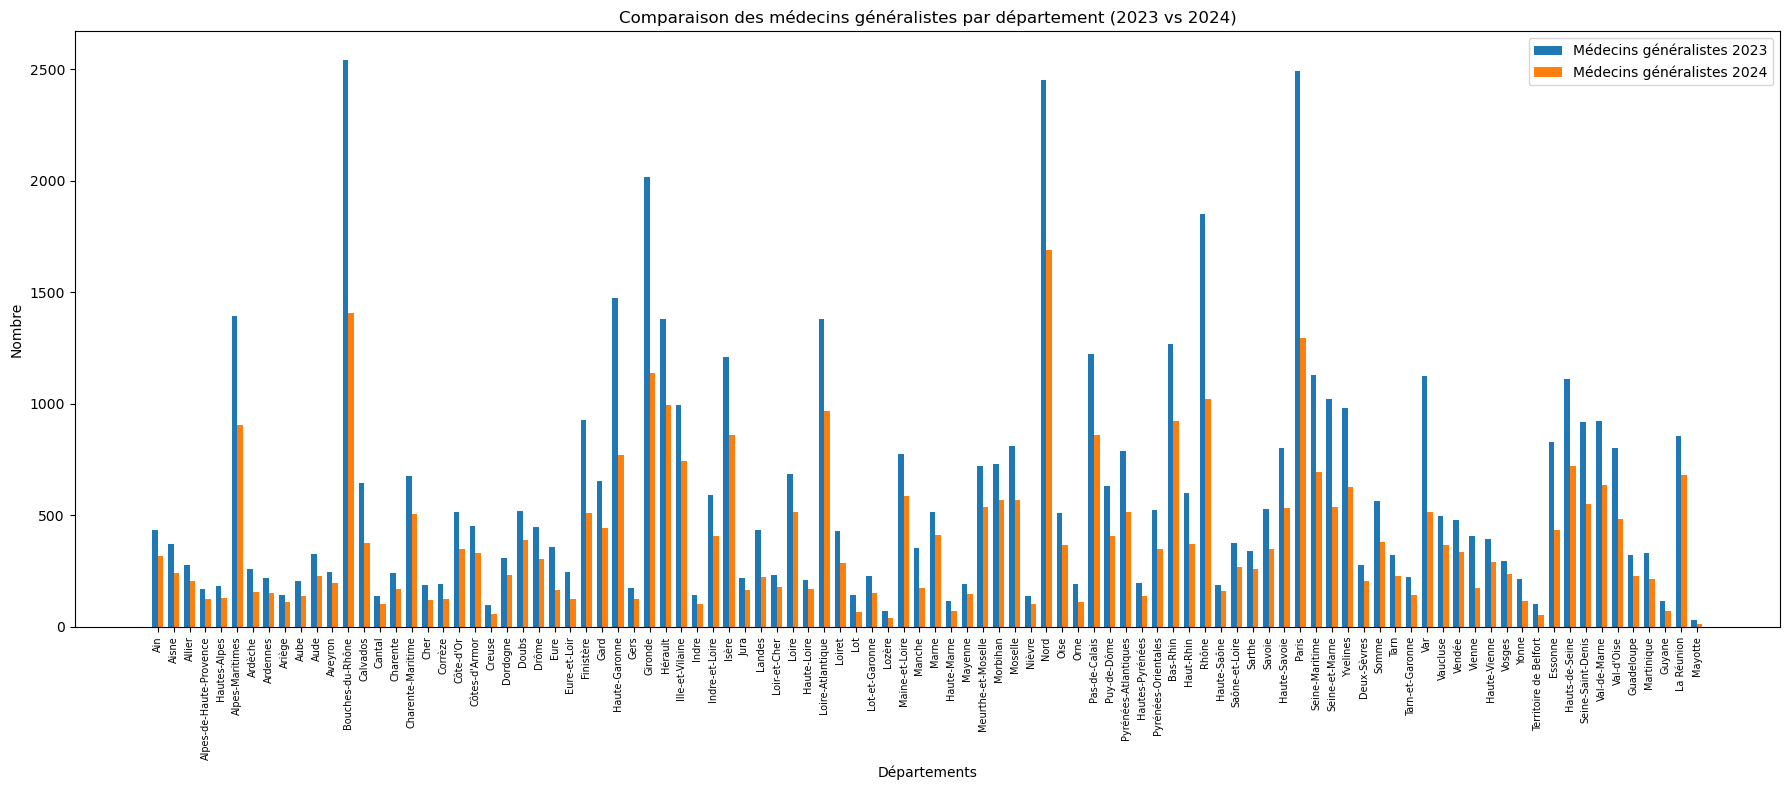

In [66]:
mp.figure(figsize=(18, 8)) # set the figure size
bar_width = 0.35 # width of the bars
indices = range(len(repartition)) # indices for the x-axis
mp.bar(indices, repartition["nb_medecins_2023"], width=bar_width, label="Médecins généralistes 2023") #histogram for 2023
mp.bar([i + bar_width for i in indices], repartition["nb_medecins_2024"], width=bar_width, label="Médecins généralistes 2024") #histogram 2024
# add labels, title, and ticks
mp.xlabel("Départements"); mp.ylabel("Nombre"); mp.title("Comparaison des médecins généralistes par département (2023 vs 2024)"); mp.xticks([i + bar_width / 2 for i in indices], repartition["Libellé"], rotation=90, fontsize=7)
mp.legend() # add legend
# adjust layout and display the plot
mp.tight_layout(); mp.show()

<br>

Pour visualiser les données sur une carte :

In [67]:
url_geojson = "https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements.geojson"
geo_df = gpd.read_file(url_geojson) # get the map

In [68]:
# function to create the interactive map
def create_medical_map(selected_year):
    if selected_year not in [2023, 2024]:
        raise ValueError("Année invalide. Choisissez 2023 ou 2024.")
    colonne = f"nb_medecins_{selected_year}" # choose the column to display according to the year  
    geo_data = geo_df.merge(repartition, left_on="code", right_on="dep_code", how="left") # merge data with geometries
    medical_map = folium.Map(location=[46.603354, 1.888334], zoom_start=6) # create map centered on France
    # add departments with color gradient
    Choropleth(geo_data=geo_data,data=repartition,columns=["dep_code", colonne],key_on="feature.properties.code",fill_color="YlGnBu",fill_opacity=0.7,
        line_opacity=0.2,nan_fill_opacity=0,legend_name=f"Médecins généralistes ({selected_year})"
    ).add_to(medical_map)
    # add tooltips for each department
    GeoJson(geo_data,tooltip=GeoJsonTooltip(fields=["nom", colonne],aliases=["Département:", "Nombre de médecins:"],localize=True)
    ).add_to(medical_map)
    display(HTML(medical_map._repr_html_()))
interact(create_medical_map,selected_year=widgets.SelectionSlider(options=[2023, 2024],description='Année:',orientation='horizontal', layout={'width': '600px'})) # widget

interactive(children=(SelectionSlider(description='Année:', layout=Layout(width='600px'), options=(2023, 2024)…

<function __main__.create_medical_map(selected_year)>

<br>

Ici, nous observons une grande différence entre les nombres de médecins généralistes en 2023 et en 2024. Cependant, ces nombres ne proviennent pas de la même base de données. La grande différence peut donc s'expliquer par le fait que la méthode utilisée pour compter le nombre de médecins généralistes n'a pas été la même pour les deux bases de données. Il est donc possible que dans l'une, des médecins retraités aient été comptés, et dans l'autre des médecins en activité aient été oubliés, et la base est incomplète.

Dans la suite des analyses, on utilisera la base de données de 2024 comme référence, car les données sont plus récentes.


<br>

On s'interesse maintenant au nombre de médecins généralistes par département en 2024, pondéré par le nombre d'habitants.

In [69]:
repartition = repartition.merge(statistiques[['dep_code', 'Estimations de population 2024']], on='dep_code') # add the column of the 2024 population
repartition = repartition.rename(columns={"Estimations de population 2024":"pop_2024"}) # rename the column
repartition.head()

,dep_code,nb_medecins_2024,Femme,Homme,nb_medecins_2023,Libellé,pop_2024
0,01,316,49,51,435,Ain,679498
1,02,240,33,67,372,Aisne,521632
2,03,204,48,52,278,Allier,332708
3,04,124,37,63,169,Alpes-de-Haute-Provence,168161
4,05,130,52,48,182,Hautes-Alpes,141661


<br> 

On calcule le ratio entre le nombre de médecins généralistes et le nombre d'habitants par département. Les chiffres sont exprimés en nombre de médecins pour 10 000 habitants.

In [70]:
repartition["ratio"] = repartition.nb_medecins_2024 / repartition.pop_2024 * 10000 # calculate the ratio of doctors per 10,000 inhabitants
repartition.head()

,dep_code,nb_medecins_2024,Femme,Homme,nb_medecins_2023,Libellé,pop_2024,ratio
0,01,316,49,51,435,Ain,679498,4.650492
1,02,240,33,67,372,Aisne,521632,4.600945
2,03,204,48,52,278,Allier,332708,6.131503
3,04,124,37,63,169,Alpes-de-Haute-Provence,168161,7.373886
4,05,130,52,48,182,Hautes-Alpes,141661,9.176838


<br>

Pour visualiser les données sur une carte :

In [71]:
carte_data = geo_df.merge(repartition, left_on="code", right_on="dep_code") # merge with the map data

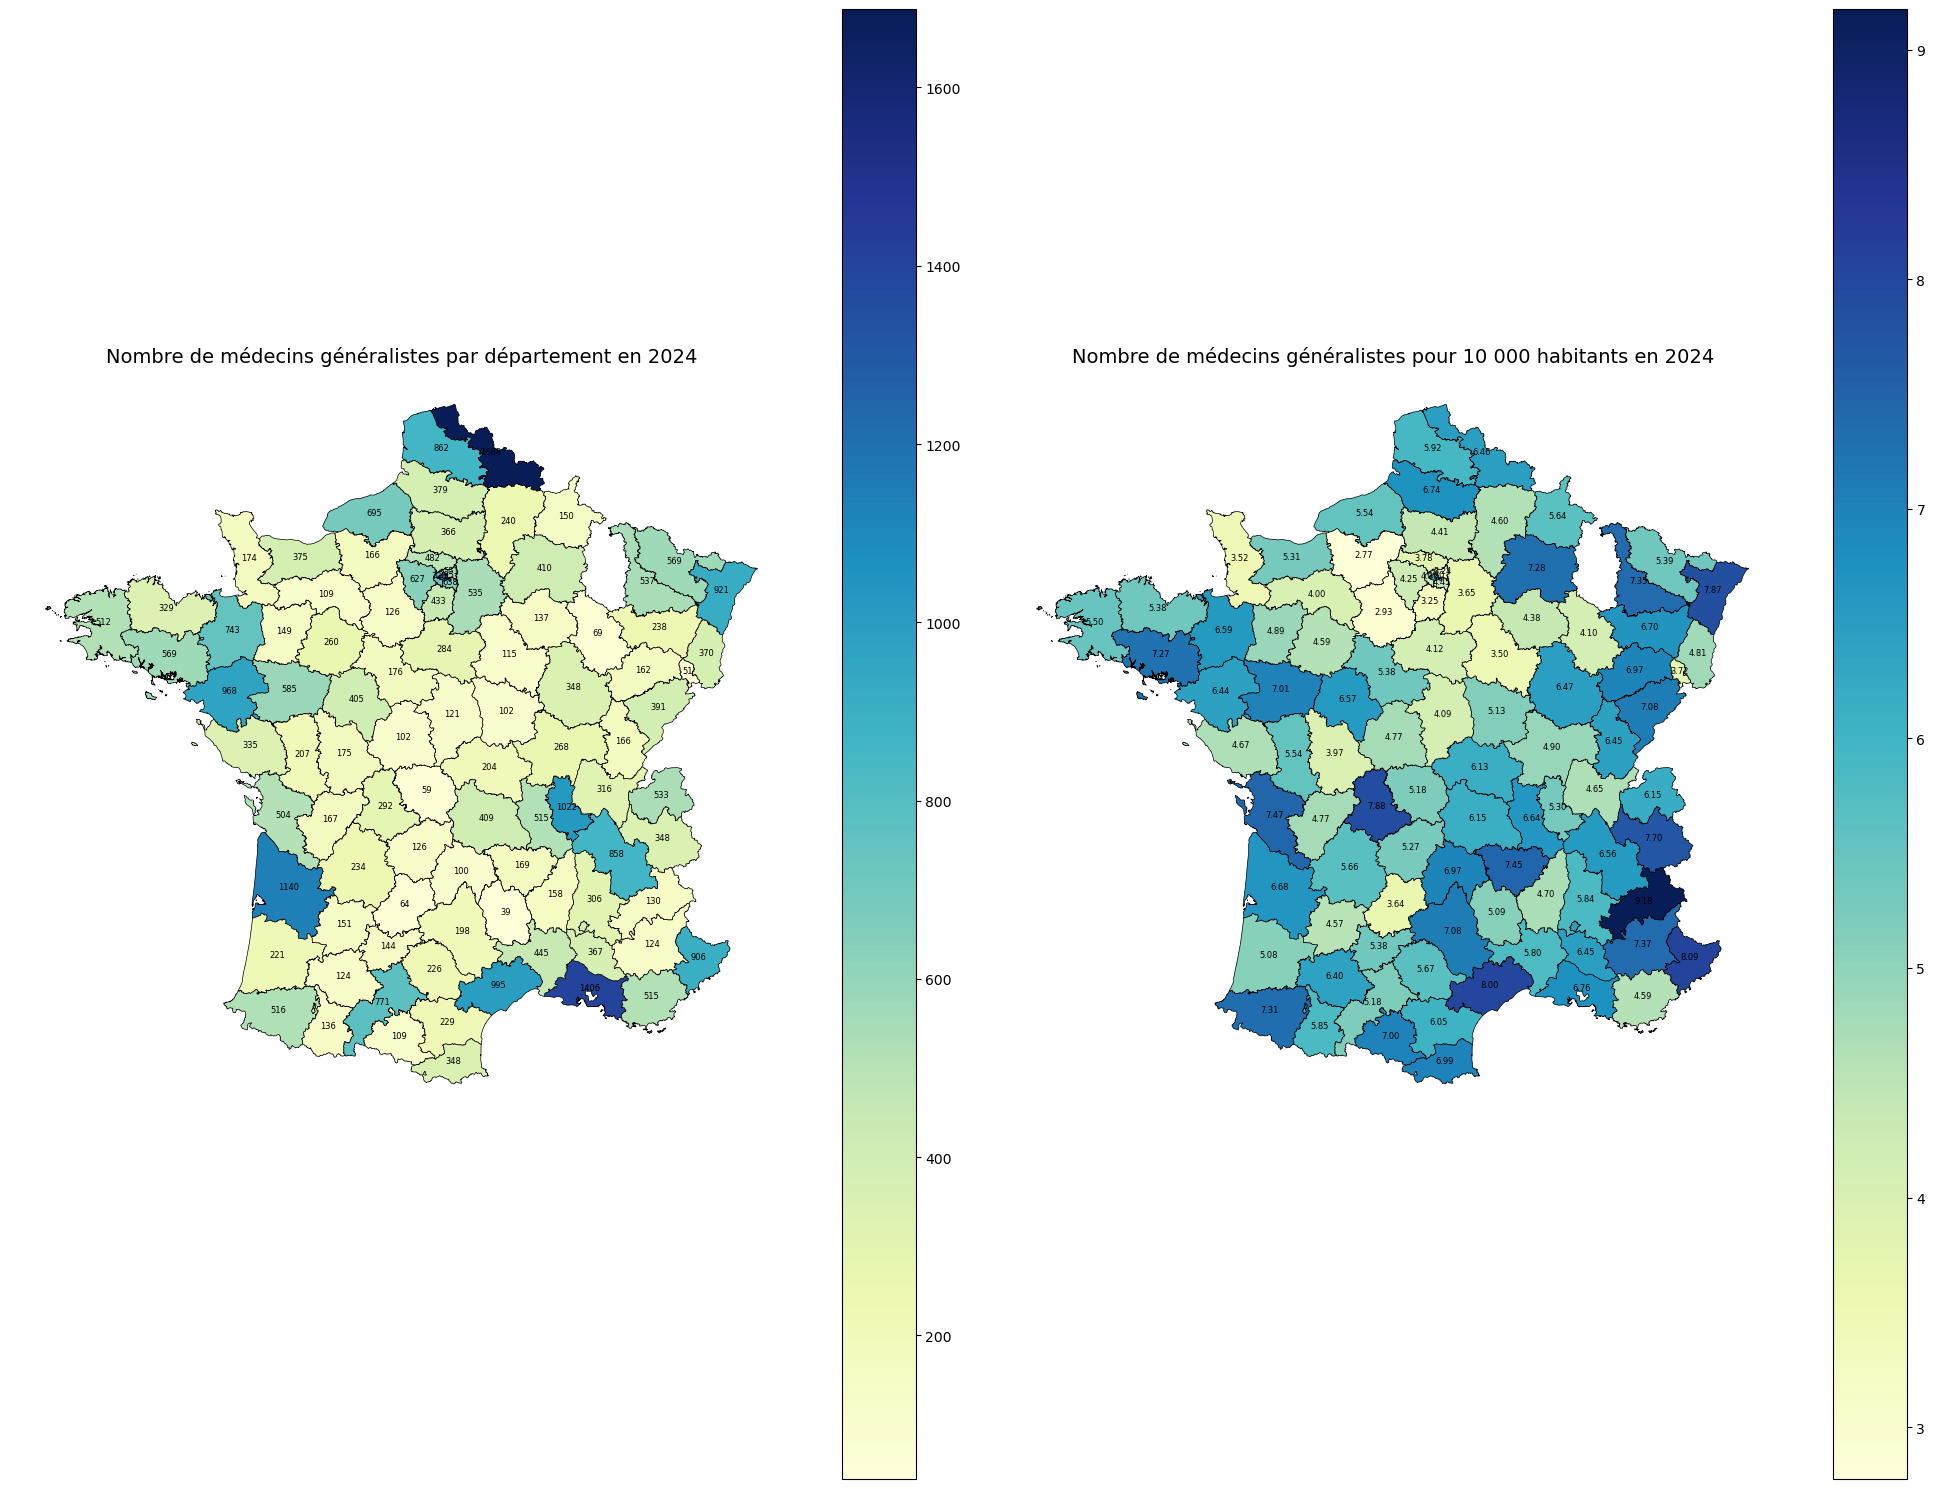

In [72]:
# display the maps of the number of doctors and the ratio per department
fig, axes = mp.subplots(1, 2, figsize=(20, 15)) # create the figure with two sub-graphs

# first figure
ax1 = carte_data.plot(column="nb_medecins_2024", cmap="YlGnBu", legend=True, edgecolor="black", linewidth=0.5, ax=axes[0])
ax1.set_title("Nombre de médecins généralistes par département en 2024", fontsize=14); ax1.set_axis_off()
# display the number of doctors for each department
for x, y, label in zip(carte_data.geometry.centroid.x, carte_data.geometry.centroid.y, carte_data["nb_medecins_2024"]):
    axes[0].text(x, y, str(label) if not pd.isna(label) else "", fontsize=6, ha="center", color="black")

# second figure
ax2 = carte_data.plot(column="ratio", cmap="YlGnBu", legend=True, edgecolor="black", linewidth=0.5, ax=axes[1])
ax2.set_title("Nombre de médecins généralistes pour 10 000 habitants en 2024", fontsize=14); ax2.set_axis_off()
# display the number of doctors for 10 000 people for each department
for x, y, label in zip(carte_data.geometry.centroid.x, carte_data.geometry.centroid.y, carte_data["ratio"]):
    axes[1].text(x, y, f"{label:.2f}" if not pd.isna(label) else "", fontsize=6, ha="center", color="black")

# adjust the layout and display the figures
mp.tight_layout(); mp.show()

<br>

On peut voir sur cette carte qu'il y a des déserts médicaux dans le centre de la France. Cependant, les données de la population par département en 2024 sont des estimations, donc ne reflètent pas forcément la réalité.

<br>

On s'intéresse maintenant à la répartition hommes/femmes des médecins généralistes en France par département, dans la carte interactive ci-dessous.

In [73]:
france_map = folium.Map(location=[46.603354, 1.888334], zoom_start=6) # Create a Folium map

for _, row in carte_data.iterrows(): # add circles for each department
    color = "blue" if row["Homme"] > row["Femme"] else "pink" # define circle color based on gender percentage
    folium.CircleMarker( # add a circle to the map
        location=[row.geometry.centroid.y, row.geometry.centroid.x], # circle location
        radius=row["ratio"] * 2, # adjust size for better visualization
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        tooltip=( # write informations on the department
            f"Departement : {row['nom']}<br>"
            f"Nombre de médecins pour 10 000 habitants : {row['ratio']:.2f}<br>"
            f"pourcentage de médecins hommes : {row['Homme']}%<br>"
            f"pourcentage de médecins femmes : {row['Femme']}%"
        ),
    ).add_to(france_map)

display(france_map)

<br>

Sur cette carte interactive, pour chaque département, on peut lire le nom du département, le nombre de médecins pour 10 000 habitants, ainsi que la répartition de médecins hommes et femmes dans le département.

Les ronds sont roses si il y a plus de médecins femmes, et bleus sinon. Leur taille varie en fonction de la concentration de médecins.


<br> <br>

---
### 2 - Tarifs d'une consultation (acte technique) par région

<br>

On fait un graphique en boîtes à moustaches, pour visualiser les valeurs anormalement élevées.

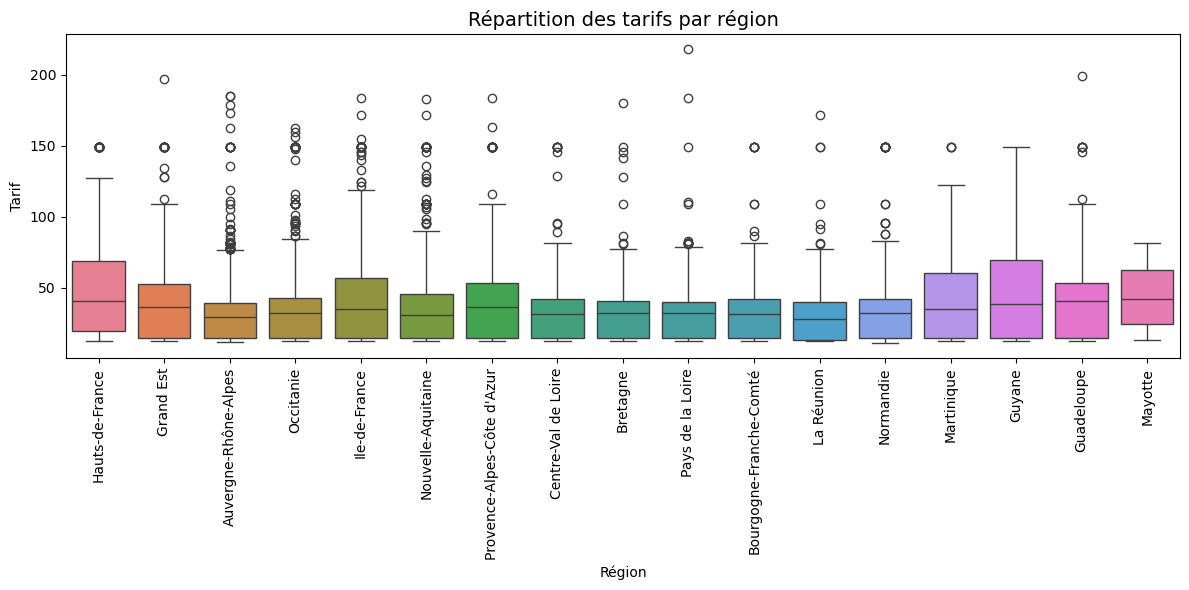

In [59]:
mp.figure(figsize=(12, 6)) # set the figure size
palette = sb.color_palette("husl", len(tarifs['region'].unique())) # generate a unique color palette based on the number of unique regions
sb.boxplot(x='region', y='tarif_1', data=tarifs, palette=palette) # create a boxplot for tarif_1 by region
mp.title("Répartition des tarifs par région", fontsize=14); mp.xticks(rotation=90); mp.xlabel("Région"); mp.ylabel("Tarif"); mp.tight_layout() # customize the plot

<br>

On remarque qu'il y a des régions dans lesquelles le tarif est en moyenne plus élevé. Cependant, dans certaines régions où le tarif est en moyenne relativement faible, comme Auvergne-Rhône-Alpes, Occitanie ou Nouvelle-Aquitaine, il y a de nombreuses valeurs extrêmes très élevées.

La région Centre-Val de Loire, qui est un désert médical comme on peut le voir sur la carte précédente, a en moyenne des tarifs relativement faibles.


<br> <br>

---
### 3 - Homonymes

<br>

On cherche des homonymes parmis les médecins généralistes, et on affiche les plus courants.

In [60]:
nom_counts = medecins['nom'].value_counts() # count the number of occurences of each name
homonymes = nom_counts[nom_counts > 1] # the names that appear more than once
homonymes.head(10)

nom
VERONIQUE SZMARAGD             6
VERONIQUE RIQUIER              6
CHRISTINE BEYLOUNE MAINARDI    6
VINCENT BRAVETTI               4
MARC PFINDEL                   4
PHILIPPE LAMBERT               4
NICOLAS MEYER                  4
LAURENT PETIT                  3
CHARLES CRIBIER                3
ERIC LAURENT                   3
Name: count, dtype: int64

In [61]:
total_personnes_partageant_nom = homonymes.sum() # total number of people who share their name with someone
moyenne_par_nom = round(total_personnes_partageant_nom / len(homonymes), 2) # average number of people per name
print("Nombre total de médecins partageant leur nom :", total_personnes_partageant_nom)
print("Moyenne de personnes par nom :", moyenne_par_nom)

Nombre total de médecins partageant leur nom : 1089
Moyenne de personnes par nom : 2.11


<br>

Il y a 1 089 médecins partageant leur nom avec un autre médecin.

Pour plus de clarté, on fait une boîte à moustache du nombre de personnes par nom, pour les noms comportant des homonymes.

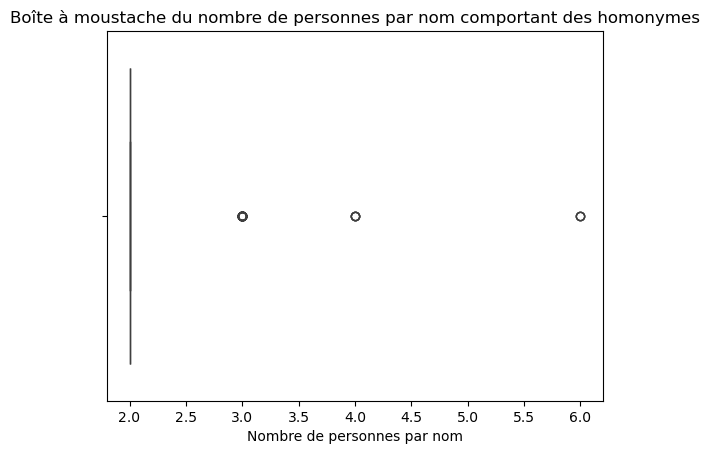

In [62]:
sb.boxplot(x=homonymes.values) # boxplot for the number of people per name, if the name appears more than once
mp.xlabel("Nombre de personnes par nom"); mp.title("Boîte à moustache du nombre de personnes par nom comportant des homonymes") # add labels and title
mp.show()

<br>

On voit qu'en grande majorité, parmis les homonymes il y a deux personnes par nom. Cependant, il y a aussi des valeurs élevées, 4 et 6 personnes partageant le même nom.